# CAB420 Assignment 1B Question 1: Template and Utilities Demo

## Overview

This notebook provides a quick demo and overview of the provided utility functions to help with Assignment 1B, Question 1.

## Utility Functions

The following cell contains utility functions to:
* Load the data
* Vectorise the data
* Plot images
* Resize all images
* Convert images to grayscale
* Build pairs or triplets of images for metric learning networks
* Plot a CMC Curve

These are provided to assist you in developing your solution.

In [29]:
#
# Utility functions for CAB420, Assignment 1B, Q1
# Author: Simon Denman (s.denman@qut.edu.au)
#
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib.pyplot as plt     # for plotting
import numpy as np                  # for reshaping, array manipulation
import cv2                          # for image loading and colour conversion
import tensorflow as tf             # for bulk image resize
import os
import glob
import random

# get the subject ID from the filename. A sample filename is 0001_c1s1_001051_00.jpg, the first
# four characters are the subject ID
#   fn:      the filename to parse
# 
#   returns: first four characters of the filename converted to an int
#
def get_subject_id_from_filename(fn):
    return int(fn[0:4])

# load the images in a directory
#   base_path: path to the data
#
#   returns:   numpy arrays of size (samples, width, height, channels), and size (samples) for 
#              images and thier labels
def load_directory(base_path):

    # find all images in the directory
    files = glob.glob(os.path.join(base_path, '*.jpg'))
    x = []
    y = []
    
    # loop through the images, loading them and extracting the subject ID
    for f in files:
        x.append(cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) / 255.0)
        y.append(get_subject_id_from_filename(os.path.basename(f)))
        
    return np.array(x), np.array(y)

# load the data
#   base_path: path to the data, within the directory that this points to there should be a 'Training' 
#              and 'Testing' directory
#
#   returns:   loaded data
#
def load_data(base_path):
    
    # load training data
    train_X, train_Y = load_directory(os.path.join(base_path, 'Training'))

    # load gallery data from the test set
    gallery_X, gallery_Y = load_directory(os.path.join(base_path, 'Testing', 'Gallery'))

    # load probe data from the test set
    probe_X, probe_Y = load_directory(os.path.join(base_path, 'Testing', 'Probe'))
    
    return train_X, train_Y, gallery_X, gallery_Y, probe_X, probe_Y

# Plot some images and their labels. Will plot the first 50 samples in a 10x5 grid
#  x: array of images, of shape (samples, width, height, channels)
#  y: labels of the images
#
def plot_images(x, y):
    fig = plt.figure(figsize=[15, 18])
    for i in range(50):
        ax = fig.add_subplot(5, 10, i + 1)
        ax.imshow(x[i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title(y[i])
        ax.axis('off')
        
# vectorise an array of images, such that the shape is changed from {samples, width, height, channels} to
# (samples, width * height * channels)
#   images: array of images to vectorise
#
#   returns: vectorised array of images
#
def vectorise(images):
    # use numpy's reshape to vectorise the data
    return np.reshape(images, [len(images), -1])

# Resize an array of images
#  images:   array of images, of shape (samples, width, height, channels)
#  new_size: tuple of the new size, (new_width, new_height)
#
#  returns:  resized array of images, (samples, new_width, new_height, channels)
#
def resize(images, new_size):
    # tensorflow has an image resize funtion that can do this in bulk
    # note the conversion back to numpy after the resize
    return tf.image.resize(images, new_size).numpy()
          
# Convert images to grayscale
#   images:  array of colour images to convert, of size (samples, width, height, 3)
#
#   returns: array of converted images, of size (samples, width, height, 1)
#
def convert_to_grayscale(images):
    # storage for converted images
    gray = []
    # loop through images
    for i in range(len(images)):
        # convert each image using openCV
        gray.append(cv2.cvtColor(images[i,:], cv2.COLOR_RGB2GRAY))
    # pack converted list as an array and return
    return np.expand_dims(np.array(gray), axis = -1)

# Create a batch of siamese data. Pairs will be evenly balanced, such that there is an
# equal number of positive and negative pairs
#   imgs:       images to use to generate data, of shape (samples, width, height, channels)
#   labels:     labels for the data, of shape (samples)
#   batch_size: number of pairs to generate 
#
#   returns:    image pairs and labels to indicate if the pairs are the same, or different
#
def get_siamese_data(imgs, labels, batch_size):

    image_a = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_b = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    label = np.zeros(batch_size);
    
    for i in range(batch_size):
        
        if (i % 2 == 0):
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 1
            while (labels[idx1] != labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)            
                
        else:
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 0
            while (labels[idx1] == labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        label[i] = l

    return [image_a, image_b], label

# Generator to continually produce batches of Siamese Data
#   imgs:       images to use to generate data, of shape (samples, width, height, channels)
#   labels:     labels for the data, of shape (samples)
#   batch_size: number of pairs to generate 
#
#   yields:     image pairs and labels to indicate if the pairs are the same, or different
#
def pair_generator(imgs, labels, batch_size):
    while True:
        [image_a, image_b], label = get_siamese_data(imgs, labels, batch_size)
        yield [image_a, image_b], label
        
# Plot the first 10 pairs of a batch, good sanity check for pair generation
#  x: images in the pairs
#  y: labels of the pairs
#
def plot_pairs(x, y):
    fig = plt.figure(figsize=[25, 6])
    for i in range(10):
        ax = fig.add_subplot(2, 10, i*2 + 1)
        ax.imshow(x[0][i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))

        ax = fig.add_subplot(2, 10, i*2 + 2)
        ax.imshow(x[1][i,:], cmap=plt.get_cmap('Greys'))    
        ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))
        
# Create a batch of triplet data.
#   imgs:       images to use to generate data, of shape (samples, width, height, channels)
#   labels:     labels for the data, of shape (samples)
#   batch_size: number of triplets to generate 
#
#   returns:    triplet of the requested batch size
#
def get_triplet_data(imgs, labels, batch_size):

    image_a = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_b = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_c = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    
    for i in range(batch_size):
        
        idx1 = random.randint(0, len(imgs) - 1)
        idx2 = random.randint(0, len(imgs) - 1)
        idx3 = random.randint(0, len(imgs) - 1)

        while (labels[idx1] != labels[idx2]):
            idx2 = random.randint(0, len(imgs) - 1)            
                
        while (labels[idx1] == labels[idx3]):
            idx3 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        image_c[i, :, :, :] = imgs[idx3,:,:,:]

    return [image_a, image_b, image_c]

# Generator to continually produce batches of Triplet Data
#   imgs:       images to use to generate data, of shape (samples, width, height, channels)
#   labels:     labels for the data, of shape (samples)
#   batch_size: number of pairs to generate 
#
#   yields:     triplet of the requested batch size
#
def triplet_generator(imgs, labels, batch_size):
    while True:
        [image_a, image_b, image_c] = get_triplet_data(imgs, labels, batch_size)
        yield [image_a, image_b, image_c], None


# Plot the first 9 triplets of a batch, good sanity check for triplet generation
#  x: images in the triplets
#
def plot_triplets(x):
    fig = plt.figure(figsize=[25, 10])
    for i in range(9):
        ax = fig.add_subplot(3, 9, i*3 + 1)
        ax.imshow(x[0][i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title('Triple ' + str(i) + ': Anchor')

        ax = fig.add_subplot(3, 9, i*3 + 2)
        ax.imshow(x[1][i,:], cmap=plt.get_cmap('Greys'))    
        ax.set_title('Triple ' + str(i) + ': Positive')

        ax = fig.add_subplot(3, 9, i*3 + 3)
        ax.imshow(x[2][i,:], cmap=plt.get_cmap('Greys'))    
        ax.set_title('Triple ' + str(i) + ': Negative')

        
# Compute a ranked histogram, which can be used to generate a CMC curve. This function will loop 
# through all probe samples. For each probe sample it will:
#  - Compare the sample to all gallery samples to get a distance between the probe sample and 
#    all gallery samples. In this case it is the L1 distance
#  - Sort the gallery samples by how close they are to the probe samples
#  - Find the location of the true match
#  - Update a ranked histogram based on this
# The ranked histogram will show how many samples are matched at each rank. For example,
# ranked_histogram[0] will record how many samples are matched at Rank-1. 
#
# This implementation assumes that there is only one sample per ID in the gallery set
#
# NOTE: L1 distance, used here, may not be appropriate for all problems. Consider the nature
# of your problem and what distance measure you should use
#
#   gallery_feat: features for the gallery data, of shape (gallery_samples, num_features)
#   gallery_Y:    IDs of the gallery samples, of shape (gallery_samples,)
#   probe_feat:   features for the probe data, of shape (probe_samples, num_features)
#   probe_Y:      IDs of the probe samples, of shape (probe_samples,)
#   verbose:      bool to indicate if debug information shoudl be printed. Be careful using this with 
#                 large feature sets, and/or lots of samples
#   
#   returns:      ranked histogram matching the probe samples to the gallery
#
def get_ranked_histogram_l1_distance(gallery_feat, gallery_Y, probe_feat, probe_Y, verbose = False):
    
    # storage for ranked histogram
    # length equal to number of unique subjects in the gallery
    ranked_histogram = np.zeros(len(np.unique(gallery_Y)))

    # loop over all samples in the probe set
    for i in range(len(probe_Y)):
        # get the true ID of this sample
        true_ID = probe_Y[i]
        if verbose:
            print('Searching for ID %d' % (true_ID))

        # get the distance between the current probe and the whole gallery, L1 distance here. Note that L1
        # may not always be the best choice, so consider your distance metric given your problem
        dist = np.linalg.norm(gallery_feat - probe_feat[i,:], axis=1, ord=1)
        if verbose:
            print(dist)

        # get the sorted order of the distances
        a = np.argsort(dist)
        # apply the order to the gallery IDs, such that the first ID in the list is the closest, the second
        # ID is the second closest, and so on
        ranked = gallery_Y[a]
        if verbose:
            print('Ranked IDs for query:')
            print(a)

        # find the location of the True Match in the ranked list
        ranked_result = np.where(ranked == true_ID)[0][0]
        if verbose:
            print(ranked_result)

        # store the ranking result in the histogram
        ranked_histogram[ranked_result] += 1
        if verbose:
            print('')
    
    if verbose:
        print(ranked_histogram)
    
    return ranked_histogram

# Convert a ranked histogram to a CMC. This simply involves computing the cumulative sum over the histogram
# and dividing it by the length of the histogram
#   ranked_hist: ranked histogram to convert to a CMC
#
#   returns:     CMC curve
#
def ranked_hist_to_CMC(ranked_hist):

    cmc = np.zeros(len(ranked_hist))
    for i in range(len(ranked_hist)):
        cmc[i] = np.sum(ranked_hist[:(i + 1)])
    
    return (cmc / len(ranked_hist))

# plot a CMC
#   cmc: cmc data to plot
#
def plot_cmc(cmc):
    fig = plt.figure(figsize=[10, 8])
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(range(1, len(cmc)+1), cmc)
    ax.set_xlabel('Rank')
    ax.set_ylabel('Count')
    ax.set_ylim([0, 1.0])
    ax.set_title('CMC Curve')      

## Utility Function Demonstration

The following presents a brief demonstration of the utility functions. These portions of code do not form part of the template, or solution, and could be commented out/removed, or you could restructure this portion of the code to form part of your solution.



In [30]:
import numpy
import numpy.matlib
import scipy
import matplotlib.pyplot as plt

from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay

train_X, train_Y, gallery_X, gallery_Y, probe_X, probe_Y = load_data('Q1/')
train_fea = train_X
train_gnd = train_Y
validate_fea = gallery_X
validate_gnd = gallery_Y
test_fea = probe_X
test_gnd = probe_Y
print("train X",train_X.shape)
print("train Y",train_Y.shape)
print("gallery X" , gallery_X.shape)
print("gallery Y",gallery_Y.shape)
print("probe X",probe_X.shape)
print("probe Y",probe_Y.shape)

# plot some images
# plot_images(gallery_X, gallery_Y)


train X (5933, 128, 64, 3)
train Y (5933,)
gallery X (301, 128, 64, 3)
gallery Y (301,)
probe X (301, 128, 64, 3)
probe Y (301,)


### Pair and Triplet Data

Pair and triplet functions are provided to pull out paired and triplet data for use with Siamese networks.

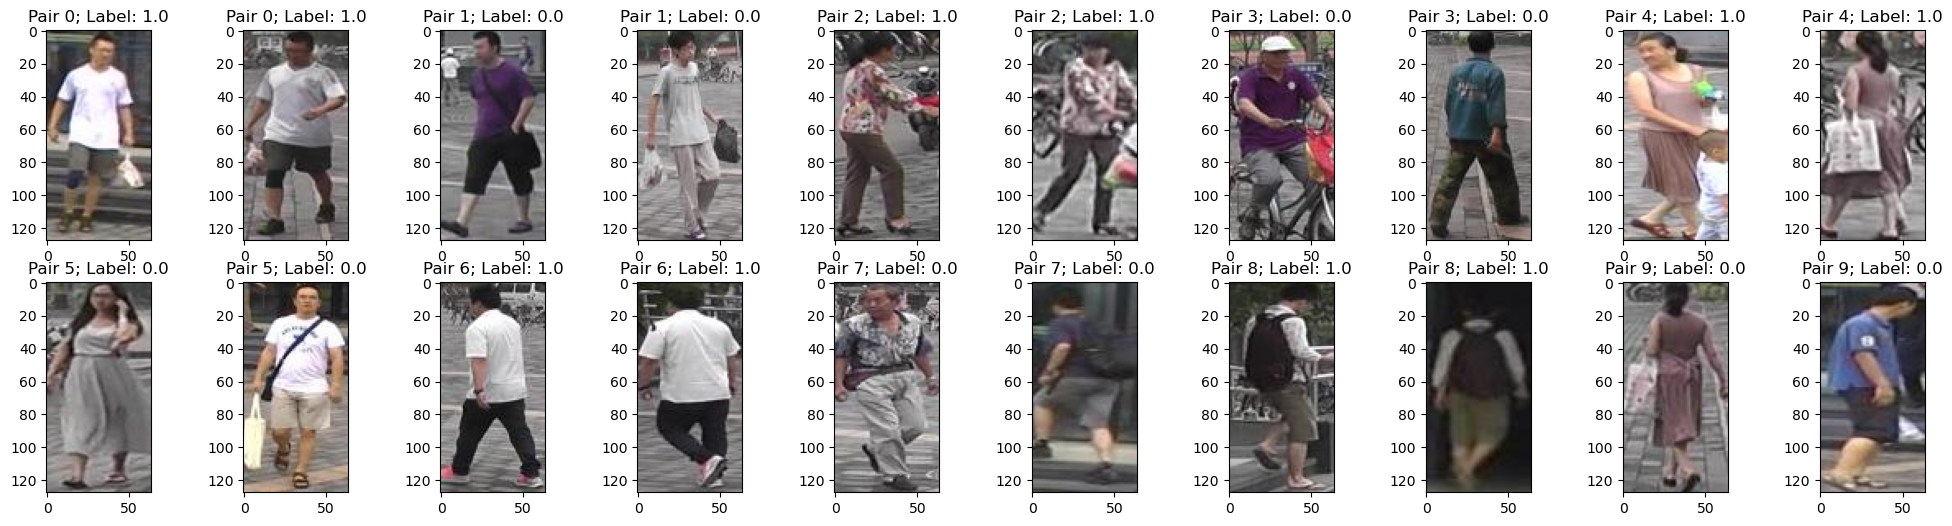

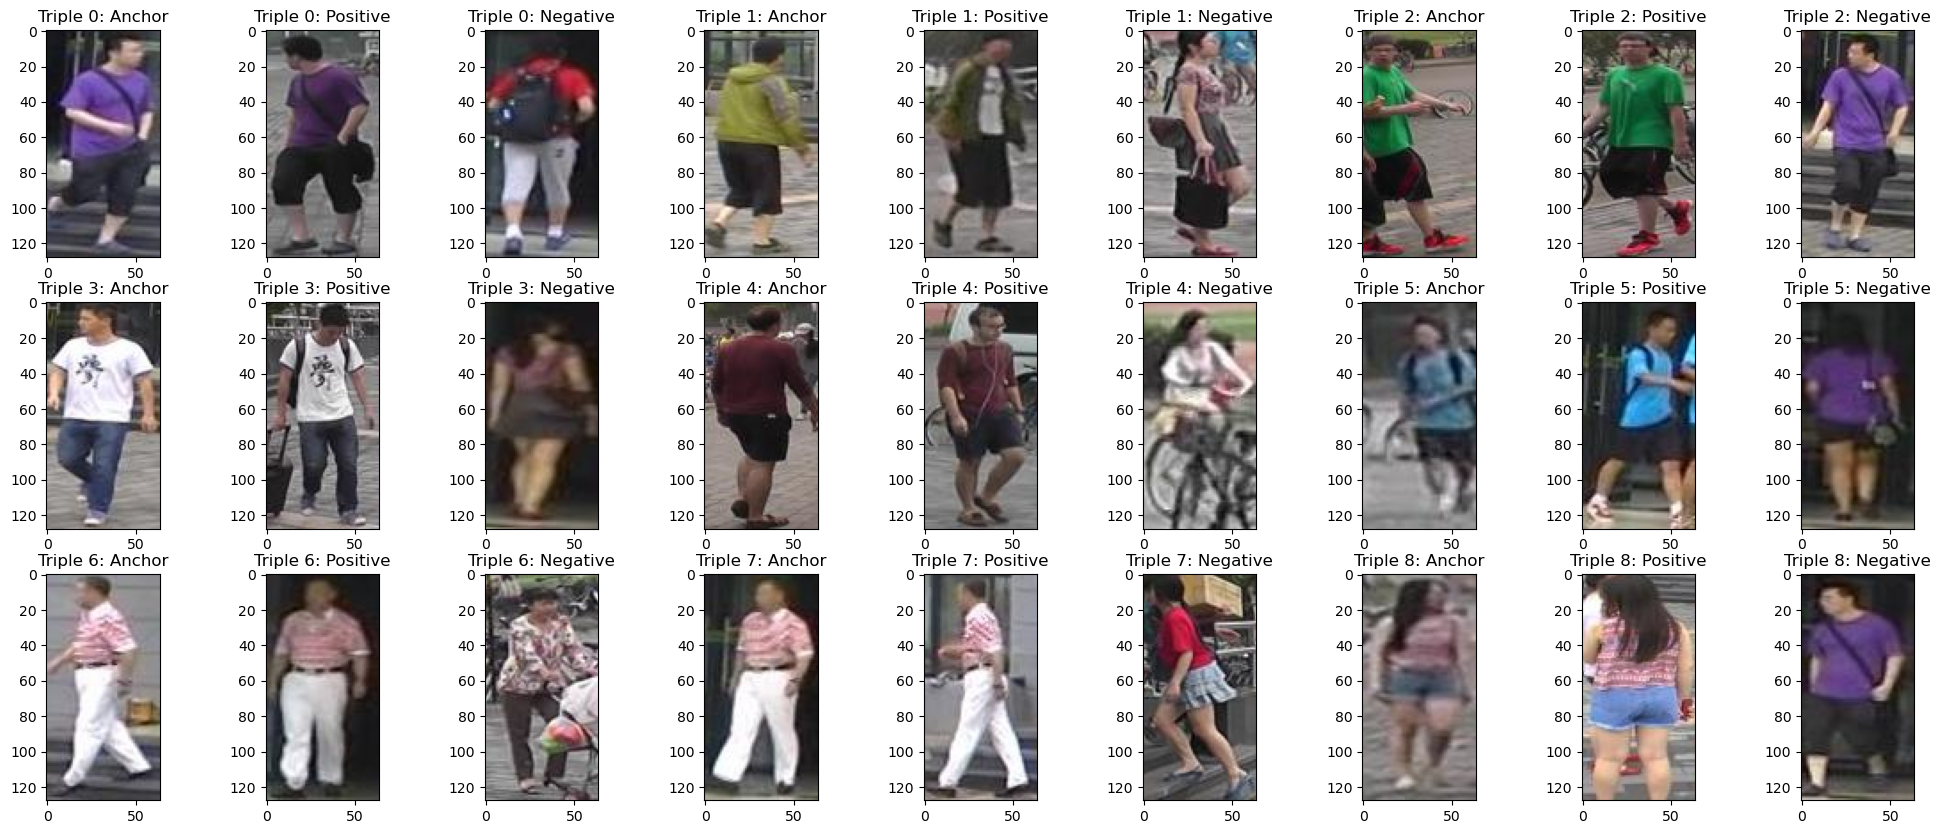

In [31]:
# create a pair generator and display a pair
pair_test = pair_generator(train_X, train_Y, 10)
x, y = next(pair_test)
plot_pairs(x, y)

# create a triplet and display a triplet
triplet_test = triplet_generator(train_X, train_Y, 9)
x, _ = next(triplet_test)
plot_triplets(x)

### Conversion and Resizing

Functions to convert images to greyscale and resize them are also provided.

(301, 64, 32, 1)
(301, 64, 32, 1)


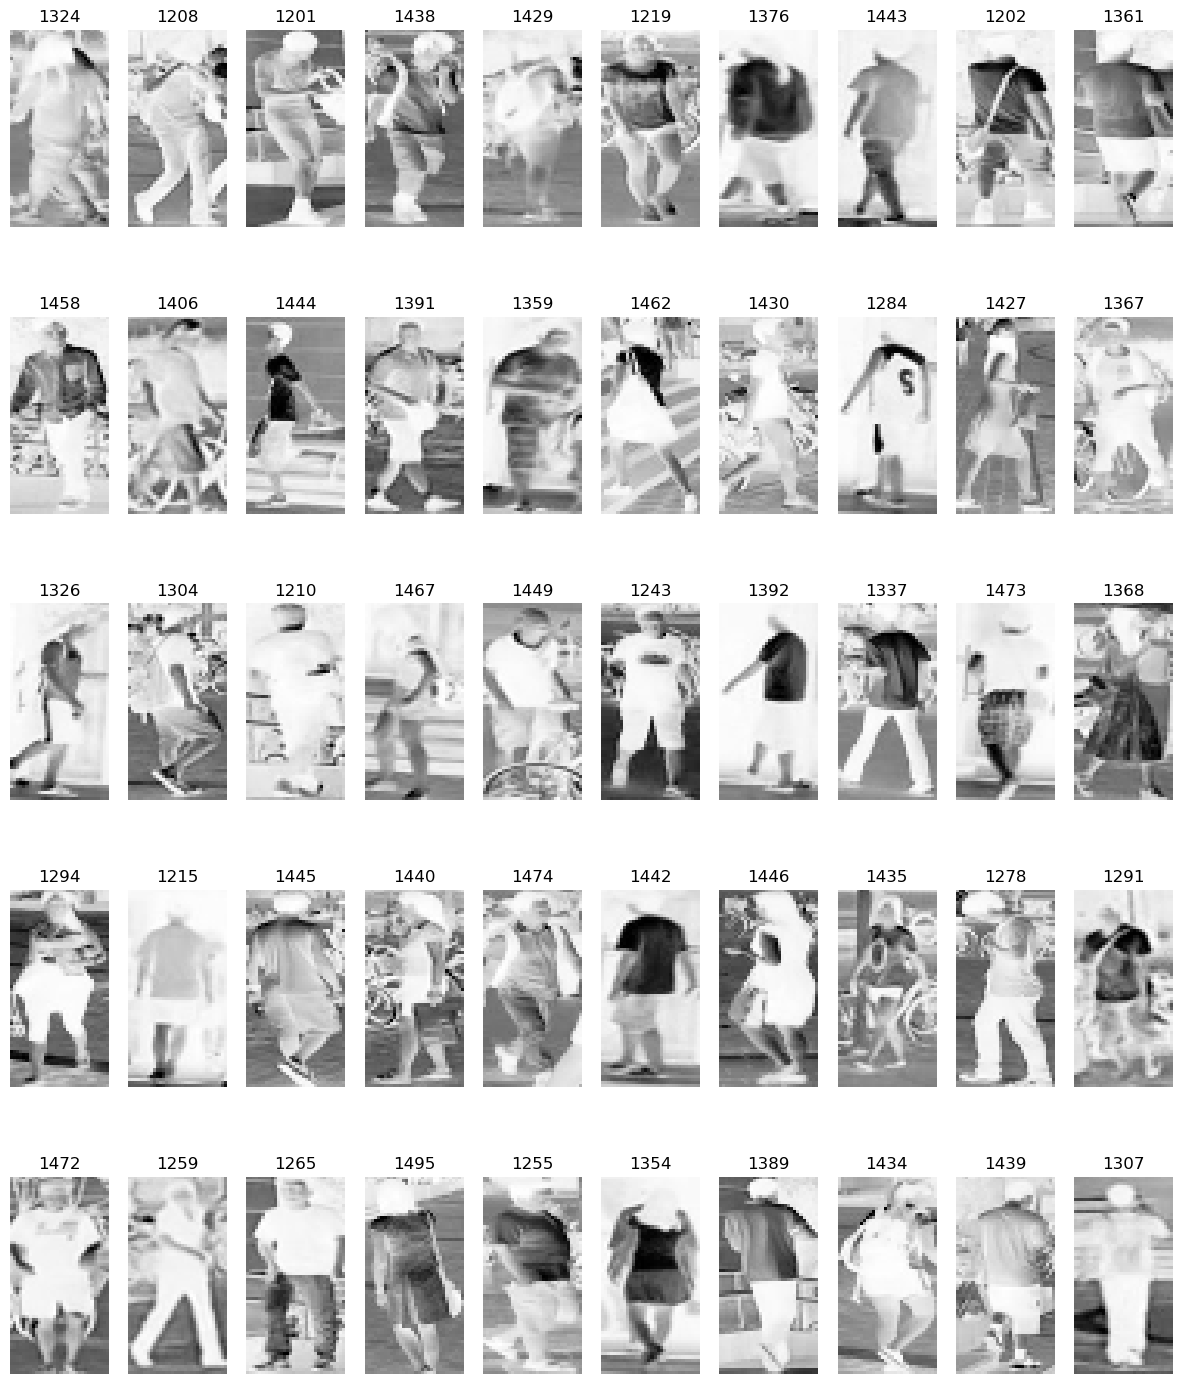

In [32]:
# resize data and convert to grayscale
gallery_X_small_gray = convert_to_grayscale(resize(gallery_X, (64, 32)))
print(gallery_X_small_gray.shape)
probe_X_small_gray = convert_to_grayscale(resize(probe_X, (64, 32)))
print(probe_X_small_gray.shape)

# plot some resized and grayscale images
plot_images(gallery_X_small_gray, gallery_Y)

### CMC Curves

Functions to create a CMC curve are provided. These assume that you have data in the following form:
* An array of gallery features, of size (gallery_samples, num_features)
* An array of gallery IDs, of size (gallery_samples)
* An array of probe features, of size (probe_samples, num_features)
* An array of probe IDs, of size (probe_samples)

Note that the provided implementation is limited in that it assumes that you have only one sample from each gallery ID in the set of gallery samples.

The process of generating a CMC is split across three functions:
* ``get_ranked_histogram_l1_distance``, which will compare each probe sample to all gallery samples and determine the location of the correct match (the rank), storing this in a histogram
* ``ranked_hist_to_CMC``, which will convert the ranked histogram to a CMC
* ``plot_cmc``, which will actually plot the CMC

Two simple examples demonstrating this are given below.

[0 1 2 3 4 5 6 7]
[[-1.32904879 -1.7960269 ]
 [-0.9887651   0.89188933]
 [ 3.35268256  2.65553756]
 [ 1.34381942  2.11416041]
 [ 3.91893585  2.11802281]
 [ 5.00956507  5.65114752]
 [ 4.12452065  7.86288342]
 [ 6.31565038  8.28154916]]
(8, 2)
[0 1 2 3 4 5 6 7]
[[-2.13173201 -2.39356552]
 [ 0.42117057  4.47888879]
 [ 2.98611096  4.73781727]
 [ 6.82576018  2.92917351]
 [ 3.25211208  5.16297631]
 [ 3.79807997  5.58367924]
 [ 9.33481638  7.00858868]
 [ 7.7648197   7.74200599]]
(8, 2)
Searching for ID 0
[ 1.40022183  4.42842175 10.53351764  7.98327735 10.56225619 15.18601011
 16.51270159 19.12249706]
Ranked IDs for query:
[0 1 3 2 4 5 6 7]
0

Searching for ID 1
[8.02513505 4.99693513 4.75486322 3.28737723 5.85863126 5.76065323
 7.08734471 9.69714018]
Ranked IDs for query:
[3 2 1 5 4 6 0 7]
2

Searching for ID 2
[10.84900392  7.820804    2.4488513   4.26594841  3.55261935  2.93678435
  4.26347584  6.87327131]
Ranked IDs for query:
[2 5 4 6 3 7 1 0]
0

Searching for ID 3
[12.88000939  9.851809

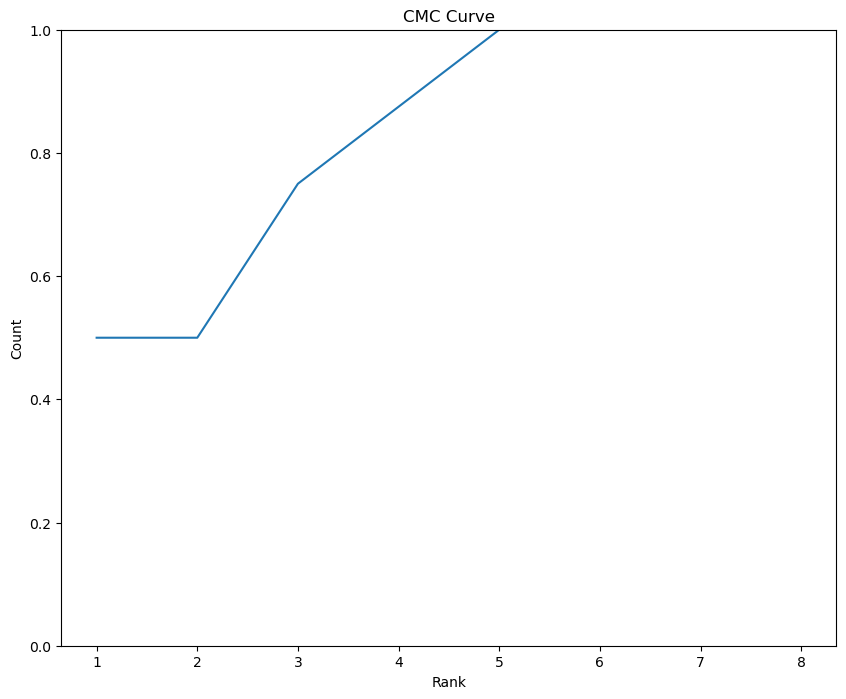

In [33]:
# we'll start off with just 8 IDs
num_ids = 8

# we'll create a list of IDs, these are the gallery and probe IDs (gallery_y and probe_y)
ID_1 = np.arange(0, num_ids, 1)
ID_2 = np.arange(0, num_ids, 1)
# we'll then generate some features
# to keep this simple, we'll use a 2D feature, i.e. each sample will have a 2D feature associated with it
# this means that we have our gallery features of size (8, 2), as we have 8 samples and 2D feaures
Feat_1 = np.transpose(np.vstack([ID_1, ID_1]) + (np.random.rand(2, num_ids) - 0.5)*4.0, (1,0))
Feat_2 = np.transpose(np.vstack([ID_2, ID_2]) + (np.random.rand(2, num_ids) - 0.5)*8.0, (1,0))

# print features and their shape to confirm what we have
print(ID_1)
print(Feat_1)
print(Feat_1.shape)
print(ID_2)
print(Feat_2)
print(Feat_2.shape)

# we can now compute the ranked histogram
# this will print out of a heap of debug data to show what's going on. In particular we see the distance between
# each probe sample and the whole gallery, and the rank of the true match, which is what is used to build the 
# ranked histogram
ranked_hist = get_ranked_histogram_l1_distance(Feat_1, ID_1, Feat_2, ID_2, True)
print(ranked_hist)
cmc = ranked_hist_to_CMC(ranked_hist)
print(cmc)
plot_cmc(cmc)

The above example results in a pretty simple CMC. Let's throw more IDs at it to get something that looks a bit better. The setup here is the same as what's above, we just have 100 gallery and probe samples now instead.

(100, 2)
(100, 2)


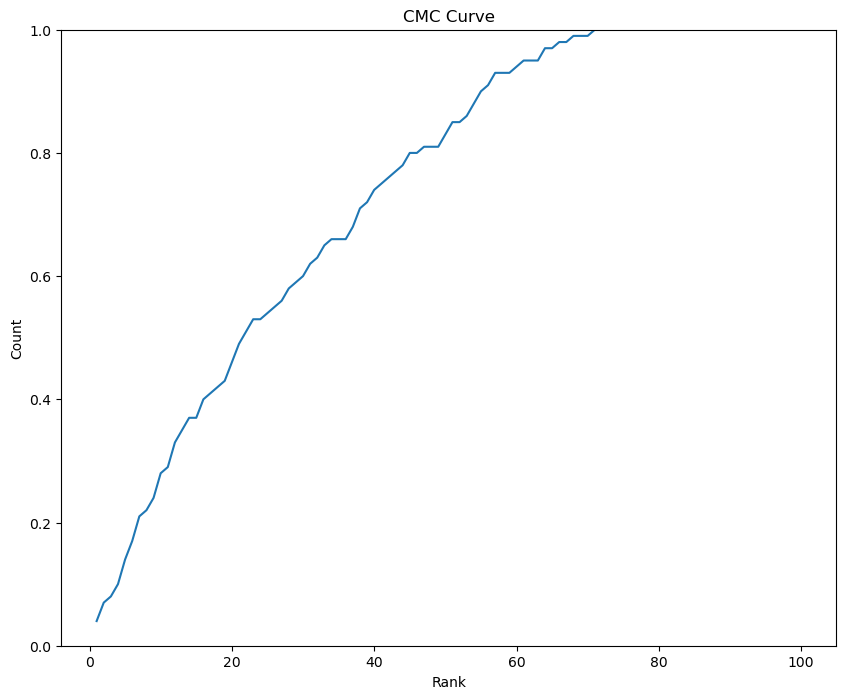

In [34]:
num_ids = 100

ID_1 = np.arange(0, num_ids, 1)
ID_2 = np.arange(0, num_ids, 1)
Feat_1 = np.transpose(np.vstack([ID_1, ID_1]) + (np.random.rand(2, num_ids) - 0.5)*20.0, (1,0))
Feat_2 = np.transpose(np.vstack([ID_2, ID_2]) + (np.random.rand(2, num_ids) - 0.5)*80.0, (1,0))
print(Feat_1.shape)
print(Feat_2.shape)

ranked_hist = get_ranked_histogram_l1_distance(Feat_1, ID_1, Feat_2, ID_2)
cmc = ranked_hist_to_CMC(ranked_hist)
plot_cmc(cmc)

With a CMC, the ideal curve is one that is always at 100%. The steeper the curve and faster it get's to 100%, the better.

### Vectorising Data

To use the images with non-DL methods, they need to be vectorised. A function is provided for this.

In [35]:
# vectorise some data
gallery_feat = vectorise(gallery_X_small_gray)
probe_feat = vectorise(probe_X_small_gray)
print(gallery_feat.shape)
print(probe_feat.shape)

#
# at this point, you have data in the shape (gallery_samples, number_of_features) and (probe_samples, number_of_features)
# and you could compare these two sets of features
#
# using colour data alone is a poor feature choice, but nonetheless you could do this.

(301, 2048)
(301, 2048)


### Your code here

This will load the data, pulling out the training set, and gallery and probe testing sets.

In [36]:
# resize data and convert to grayscale
train_X_small_gray = convert_to_grayscale(resize(train_X, (64, 32)))
gallery_X_small_gray = convert_to_grayscale(resize(gallery_X, (64, 32)))
probe_X_small_gray = convert_to_grayscale(resize(probe_X, (64, 32)))

# train_Y_small_gray = convert_to_grayscale(resize(train_Y, (64, 32)))
# gallery_Y_small_gray = convert_to_grayscale(resize(gallery_Y, (64, 32)))
# probe_Y_small_gray = convert_to_grayscale(resize(probe_Y, (64, 32)))


In [37]:
# vectorise train_X, gallery and probe data
train_X_vect = vectorise(train_X_small_gray)
print(train_X_vect.shape)
gallery_X_vect = vectorise(gallery_X_small_gray)
print(gallery_X_vect.shape)
probe_X_vect = vectorise(probe_X_small_gray)
print(probe_X_vect.shape)

# fitting a PCA model over the training data
pca = decomposition.PCA()
pca.fit(train_X_vect)

# train_Y_vect = vectorise(train_Y_small_gray)
# print(train_Y_vect.shape)
# gallery_Y_vect = vectorise(gallery_Y_small_gray)
# print(gallery_Y_vect.shape)
# probe_Y_vect = vectorise(probe_Y_small_gray)
# print(probe_Y_vect.shape)



(5933, 2048)
(301, 2048)
(301, 2048)


PCA()

In [38]:
# applying transform to the gallery and probe data
train_transformed = pca.transform(train_X_vect)
print(train_transformed.shape)
gallery_transformed = pca.transform(gallery_X_vect)
print(gallery_transformed.shape)
probe_transformed = pca.transform(probe_X_vect)
print(probe_transformed.shape)

cumulative_sum = numpy.cumsum(pca.explained_variance_ratio_, axis=0)
top95 = numpy.where(cumulative_sum > 0.95)[0][0]

transformed_train_95 = train_transformed[:, 0:top95]
transformed_test_95 = probe_transformed[:, 0:top95]

# transform
# transformed_train_Y = pca.transform(train_Y_vect)
# print(transformed_train_Y.shape)
# transformed_gallery_Y = pca.transform(gallery_Y_vect)
# print(transformed_gallery_Y.shape)
# transformed_probe_Y = pca.transform(probe_Y_vect)
# print(transformed_probe_Y.shape)



# def eval_model(model, X_train, Y_train, X_test, Y_test):
#     fig = plt.figure(figsize=[25, 8])
#     ax = fig.add_subplot(1, 2, 1)
#     conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax)
#     pred = model.predict(X_train)
#     conf.ax_.set_title('Training Set Performance: %s' % (sum(pred == Y_train)/len(Y_train)));
#     ax = fig.add_subplot(1, 2, 2)
#     conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax)
#     pred = model.predict(X_test)
#     conf.ax_.set_title('Test Set Performance: %s' % (sum(pred == Y_test)/len(Y_test)));
    
# cknn_95 = KNeighborsClassifier(n_neighbors=10, weights='distance')
# cknn_95.fit(transformed_train_95, train_Y)
# eval_model(cknn_95, transformed_train_95, train_Y, transformed_test_95, probe_Y)  






(5933, 2048)
(301, 2048)
(301, 2048)


[8. 3. 1. 2. 3. 2. 5. 2. 0. 4. 6. 4. 0. 2. 2. 3. 2. 0. 3. 1. 2. 3. 0. 1.
 0. 1. 0. 4. 0. 1. 1. 0. 2. 1. 1. 2. 2. 2. 3. 2. 1. 2. 1. 3. 0. 0. 1. 2.
 0. 3. 2. 3. 3. 1. 1. 1. 2. 1. 0. 1. 0. 1. 3. 1. 0. 1. 1. 2. 3. 1. 2. 0.
 0. 0. 0. 0. 1. 0. 1. 0. 2. 2. 1. 2. 2. 0. 0. 1. 3. 0. 1. 0. 0. 0. 1. 1.
 1. 4. 0. 1. 0. 1. 2. 0. 2. 1. 1. 0. 3. 1. 1. 1. 1. 1. 2. 1. 1. 0. 0. 1.
 0. 2. 1. 2. 0. 0. 1. 1. 1. 2. 0. 1. 1. 2. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.
 2. 1. 0. 1. 0. 2. 1. 0. 0. 2. 1. 2. 1. 0. 0. 0. 0. 0. 3. 2. 0. 1. 1. 3.
 0. 2. 1. 0. 0. 0. 2. 0. 1. 1. 0. 1. 0. 0. 0. 3. 0. 3. 2. 0. 0. 0. 0. 2.
 0. 2. 1. 2. 0. 0. 0. 0. 0. 0. 2. 1. 0. 1. 1. 1. 2. 0. 1. 0. 1. 1. 1. 0.
 1. 0. 0. 1. 2. 0. 1. 2. 0. 1. 1. 1. 1. 2. 1. 0. 1. 0. 1. 1. 2. 0. 2. 0.
 1. 2. 1. 0. 0. 0. 1. 0. 0. 1. 1. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 1.
 0. 1. 1. 0. 1. 0. 1. 0. 2. 3. 0. 0. 1. 0. 0. 3. 1. 0. 1. 2. 1. 0. 0. 0.
 1. 0. 2. 0. 2. 1. 1. 0. 0. 0. 0. 0. 0.]
[0.02657807 0.03654485 0.03986711 0.04651163 0.05647841 0.06312292
 0.07973422 0.08

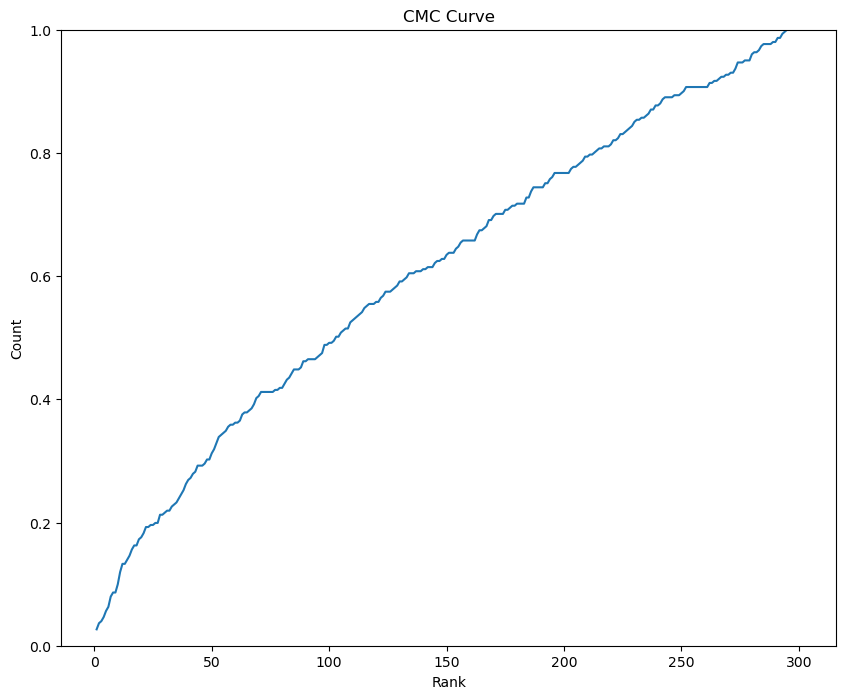

In [39]:
# compute histogram
histo_ranked = get_ranked_histogram_l1_distance(gallery_transformed, gallery_Y, probe_transformed, probe_Y, verbose = False)
print(histo_ranked)

# get CMC 
cmc = ranked_hist_to_CMC(histo_ranked)
print(cmc)

# plot CMC
plot_cmc(cmc)

#### Deep Learning Method

In [42]:

import random
import numpy
import numpy.matlib
import scipy
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay

# for consistency
random.seed(4)

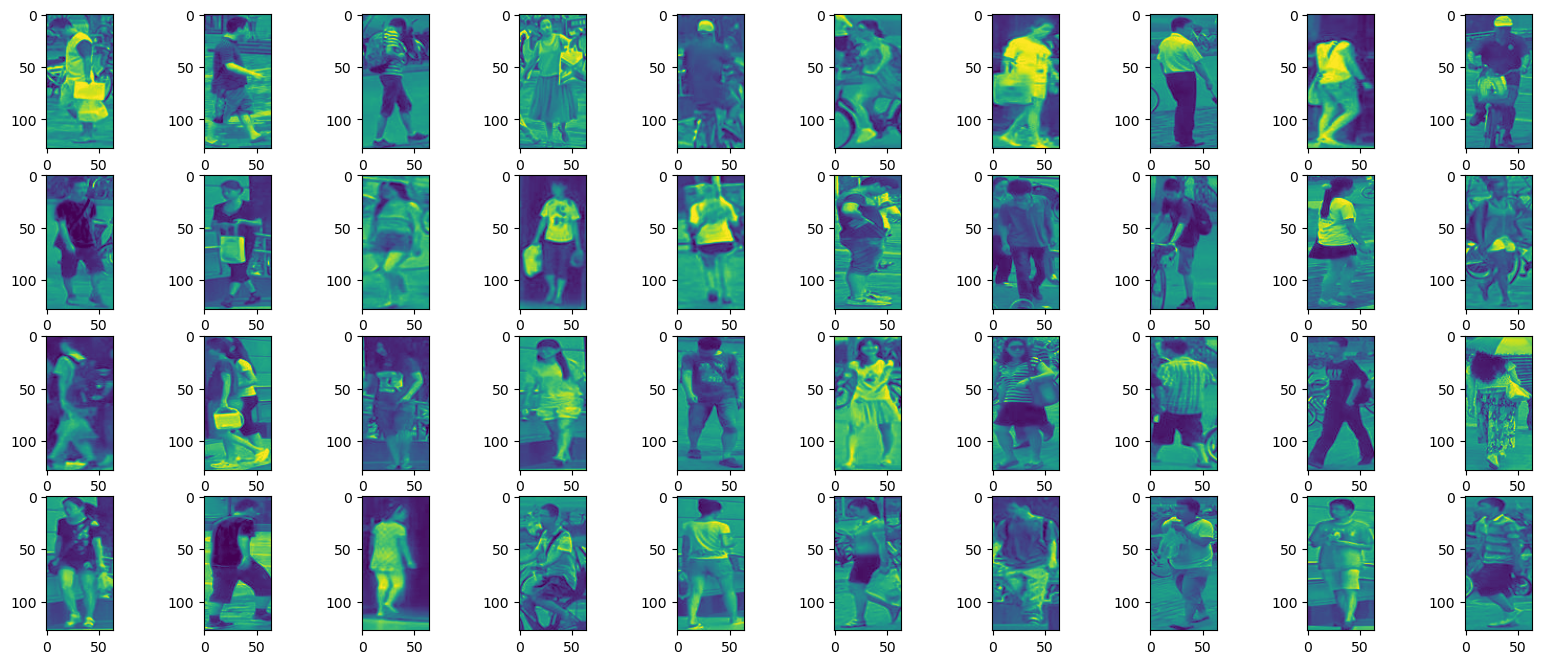

In [41]:
# train_fea = train_X
# train_gnd = train_Y
# validate_fea = gallery_X
# validate_gnd = gallery_Y
# test_fea = probe_X
# test_gnd = probe_Y


fig = plt.figure(figsize=[20, 8])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 1)
    ax.imshow(train_fea[i,:,:,0])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 21)
    ax.imshow(test_fea[i,:,:,0])    

## Network Setup

We're going to use a Siamese network, and so we're going to borrow heavily from the lecture example.

In [ ]:
def GetSiameseData(imgs, labels, batch_size):

    image_a = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    image_b = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    label = numpy.zeros(batch_size);
    
    for i in range(batch_size):
        
        if (i % 2 == 0):
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 1
            while (labels[idx1] != labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)            
                
        else:
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 0
            while (labels[idx1] == labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        label[i] = l

    return [image_a, image_b], label

def GetTripletData(imgs, labels, batch_size):

    image_a = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    image_b = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    image_c = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    
    for i in range(batch_size):
        
        idx1 = random.randint(0, len(imgs) - 1)
        idx2 = random.randint(0, len(imgs) - 1)
        idx3 = random.randint(0, len(imgs) - 1)

        while (labels[idx1] != labels[idx2]):
            idx2 = random.randint(0, len(imgs) - 1)            
                
        while (labels[idx1] == labels[idx3]):
            idx3 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        image_c[i, :, :, :] = imgs[idx3,:,:,:]

    return [image_a, image_b, image_c]

def TripleGenerator(imgs, labels, batch_size):
    while True:
        [image_a, image_b, image_c] = GetTripletData(imgs, labels, batch_size)
        yield [image_a, image_b, image_c], None
        
test = TripleGenerator(train_fea_reshape, train_gnd, 9)
x, _ = next(test)

fig = plt.figure(figsize=[25, 10])
for i in range(9):
    ax = fig.add_subplot(3, 9, i*3 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Triple ' + str(i) + ': Anchor')
    
    ax = fig.add_subplot(3, 9, i*3 + 2)
    ax.imshow(x[1][i,:,:,0])    
    ax.set_title('Triple ' + str(i) + ': Positive')

    ax = fig.add_subplot(3, 9, i*3 + 3)
    ax.imshow(x[2][i,:,:,0])    
    ax.set_title('Triple ' + str(i) + ': Negative')        

In [ ]:
def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):
    
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    return x

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)
    
    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):
    
    x = inputs
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))
    
    x = layers.Flatten()(x)
    
    for i in fc:
        x = fc_block(x, i, dropout)
        
    return x

In [ ]:
embedding_size = 32
dummy_input = keras.Input((32, 32, 1))
base_network = vgg_net(dummy_input, [8, 16, 32], [256], 0.2, 0)
embedding_layer = layers.Dense(embedding_size, activation=None)(base_network)
base_network = keras.Model(dummy_input, embedding_layer, name='SiameseBranch')

class TripletLossLayer(layers.Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        
        anchor = K.l2_normalize(anchor, axis=1)
        positive = K.l2_normalize(positive, axis=1)
        negative = K.l2_normalize(negative, axis=1)

        p_dist = K.sum(K.square(anchor-positive), axis=-1)
        n_dist = K.sum(K.square(anchor-negative), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss
    
input_anchor = keras.Input((32, 32, 1), name='Anchor')
input_positive = keras.Input((32, 32, 1), name='Positive')
input_negative = keras.Input((32, 32, 1), name='Negative')

embedding_anchor = base_network(input_anchor)
embedding_positive = base_network(input_positive)
embedding_negative = base_network(input_negative)

margin = 1
loss_layer = TripletLossLayer(alpha=margin, name='triplet_loss_layer')([embedding_anchor, embedding_positive, embedding_negative])

In [ ]:
triplet_network = keras.Model(inputs=[input_anchor, input_positive, input_negative], outputs=loss_layer)
triplet_network.summary()

In [ ]:
triplet_network.compile(optimizer=keras.optimizers.RMSprop())

batch_size = 128
training_gen = TripleGenerator(train_fea_reshape, train_gnd, batch_size)
triplet_test_x = GetTripletData(test_fea_reshape, test_gnd, 1000)

triplet_network.fit(training_gen, steps_per_epoch = 60000 // batch_size, epochs=10, validation_data=(triplet_test_x, None))

In [ ]:
embeddings = base_network.predict(train_fea_reshape)
tsne_embeddings = TSNE(random_state=4).fit_transform(embeddings)
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = train_gnd.flatten());